In [2]:
from numpy import *
from numpy import pi as π
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive

In [3]:
class GaussianBeam:
    """
    This class is used to represent a General Astigmatic Gaussian Beam.
    """
    def __init__(self,P:float64,λ:float64,q10:complex128,q20:complex128,θ:complex128):
        self.P = P
        self.λ = λ
        self.q1 = lambda z: z + q10.real + 1.j*q10.imag
        self.q2 = lambda z: z + q20.real + 1.j*q20.imag
        self.θ = θ

        self.k = 2.*π/λ
        self.Q = lambda z: array([
            [(cos(θ)**2.)/self.q1(z) + (sin(θ)**2.)/self.q2(z),      0.5*sin(2.*θ)*(1./self.q1(z) - 1./self.q2(z))],
            [0.5*sin(2.*θ)*(1./self.q1(z - 1./self.q2(z))),      (sin(θ)**2.)/self.q1(z) + (cos(θ)**2.)/self.q2(z)]
        ],complex128)
        self.E0 = lambda z: sqrt(P/λ*sqrt(
            4.*self.Q(z)[1,1].imag)*self.Q(z)[2,2].imag - (self.Q(z)[1,2] + self.Q(z)[2,1])**2.
        )
        self.η = lambda z: 0.5*(atan(self.q1(z).real/self.q1(z).imag) + atan(self.q2(z).real/self.q2(z).imag))
        self.E = lambda r,z: self.E0(z)*exp(1.j*self.η(z) - 1.j*(self.k/2.)*(r.T @ self.Q(z) @ r))

    def intensity_phase_ellipses(self,z):
            α = self.θ.real
            β = self.θ.imag
            
            ρ1 = self.q1(z).real/(abs(self.q1(z))**2.)
            ρ2 = self.q2(z).real/(abs(self.q2(z))**2.)

            ω1 = self.q1(z).imag/(abs(self.q1(z))**2.)
            ω2 = self.q2(z).imag/(abs(self.q2(z))**2.)

            φ_w0 = 0.5*arctan2(-(ρ1 - ρ2)*tanh(2.*β),(ω1 - ω2))
            φ_w = unwrap(φ_w0 + α, period=π)

            φ_R0 = 0.5*arctan2( (ω1 - ω2)*tanh(2.*β),(ρ1 - ρ2))
            φ_R = unwrap(φ_R0 + α, period=π)

            w1 = 1./sqrt((self.k/4.)*(ω1 + ω2 + sqrt(((ω1 - ω2)**2.)*(cosh(2*β)**2.) + ((ρ1 - ρ2)**2.)*(sinh(2*β)**2.))))
            w2 = 1./sqrt((self.k/4.)*(ω1 + ω2 - sqrt(((ω1 - ω2)**2.)*(cosh(2*β)**2.) + ((ρ1 - ρ2)**2.)*(sinh(2*β)**2.))))

            R1 = 2./(ρ1 + ρ2 + sqrt(((ρ1 - ρ2)**2.)*(cosh(2*β)**2.) + ((ω1 - ω2)**2.)*(sinh(2*β)**2.)))
            R2 = 2./(ρ1 + ρ2 - sqrt(((ρ1 - ρ2)**2.)*(cosh(2*β)**2.) + ((ω1 - ω2)**2.)*(sinh(2*β)**2.)))

            return [φ_w, w1, w2], [φ_R, R1, R2]
        

In [4]:
def Rx(a):
    """ Matriz de rotação em torno do eixo x por um ângulo a (em radianos). """
    return array([
        [1, 0, 0],
        [0, cos(a), -sin(a)],
        [0, sin(a), cos(a)]
    ])

def Ry(b):
    """ Matriz de rotação em torno do eixo y por um ângulo b (em radianos). """
    return array([
        [cos(b), 0, sin(b)],
        [0, 1, 0],
        [-sin(b), 0, cos(b)]
    ])

def Rz(c):
    """ Matriz de rotação em torno do eixo z por um ângulo c (em radianos). """
    return array([
        [cos(c), -sin(c), 0],
        [sin(c), cos(c), 0],
        [0, 0, 1]
    ])

def Rtot(a, b, c):
    """ Combinar rotações em torno dos eixos x, y e z. """
    return dot(Rz(c), dot(Ry(b), Rx(a)))

In [81]:
from numpy import *
import plotly.graph_objects as go

λ = 1064e-9
q1 = 66e-3j
q2 = -500e-3 + 266e-3j
θ = (20. + 10.j)*π/180.

gb = GaussianBeam(1,λ,q1,q2,θ)

# Exemplo de dados (deve ser substituído pelos seus dados reais)
z = linspace(-1, 1, 100)  # Valores de z

waist_data, _ = gb.intensity_phase_ellipses(z)
φ_w, w1, w2 = waist_data

# Criar o gráfico
fig = go.Figure()

for zi, w1i, w2i, φ_wi in zip(z, w1, w2, φ_w):
    t = linspace(0., 2. * π, 100)
    x = w1i * cos(t)
    y = w2i * sin(t)
    
    # Aplicar rotação da elipse
    x_rot = x * cos(φ_wi) - y * sin(φ_wi)
    y_rot = x * sin(φ_wi) + y * cos(φ_wi)
    
    # Adiciona os pontos rotacionados às listas
    # Plotar a elipse no plano xy a uma altura z

    XYZ = dot(Rx(0), stack([x_rot,y_rot,full_like(t,zi)],axis=0))
    
    X = XYZ[0,:]
    Y = XYZ[1,:]
    Z = XYZ[2,:]

    fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='lines'))


fig.update_layout(
    title="Elipses como Curvas 3D",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    autosize=True
)


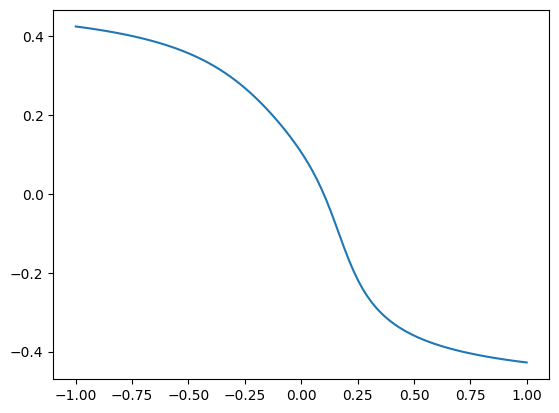

In [6]:
plt.plot(z,(φ_w)/π)